# Noise2Void on 3D Patches applied to Refined Dataset

In this experiment we trained a model on the REFINED train set, using no augmentations and a 3D patch size of 64x64x64. 

The following command was used to train the model:

```bash
python n2v_train.py 
-e .env_hpc 
--level DEBUG 
--train_dataset_name=train 
--validation_dataset_name=val 
--DATASET_FOLDER=/scratch/edoardo.giacomello/calcium_imaging/refined 
--experiment_name=REFINED_N2V_3 
--patch_size_z=64 
--batch_size=1 
--axes=ZYX
```

Predictions were made on the train set to enable further models to be trained on the predictions. The following command was used to make predictions:

```bash
python n2v_predict.py
 -e .env_hpc 
 --level DEBUG 
 --dataset_name=train 
 --DATASET_FOLDER=/scratch/edoardo.giacomello/calcium_imaging/refined 
 --experiment_name=REFINED_N2V_3 
 --patch_size_z=64 
 --batch_size=4 
 --axes=ZYX
```

# Model Output

Showing the input image, the model output and the model output with the microscope background noise subtracted from it.

In [1]:
import tifffile
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from pathlib import Path
import numpy as np


input_image = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/refined/train/20ms_20%_Yoda1_005.tif")
output_image = tifffile.imread("output/REFINED_N2V_3/train/20ms_20%_Yoda1_005.tif")
average_noise = tifffile.imread("/localscratch/calcium_imaging_dataset/calcium_imaging/average_image.tif")
stacked_to_show = np.stack([input_image, output_image, output_image-average_noise])

In [5]:
from typing import Literal

def display_image_with_slider(images, vlim: Literal["stack", "frame", "all"]="stack", titles: np.ndarray = None):
    """
        Shows a set of images side-by-side with a common slider for the time dimension.
        Args:
            - images: A np.ndarray of images of shape [N, T, H, W] or [T, H, W]

    """
    if images.ndim == 3:
        images = images[None, ...]

    N, T, Y, X = images.shape
    all_vmin = [i.min() for i in images] if vlim == "stack" else [images.min() for i in range(N)] 
    all_vmax = [i.max() for i in images] if vlim == "stack" else [images.max() for i in range(N)]

    def update_image(t):
        fig, axs = plt.subplots(1, N, squeeze=False, figsize=(N*10, 10))
        for n, ax in enumerate(axs[0]):
            img_to_show = images[n, t]
            if vlim == "frame":
                vmin, vmax = img_to_show.min(), img_to_show.max()
            else:
                vmin, vmax = all_vmin[n], all_vmax[n]
            ax.imshow(img_to_show, cmap='gray', vmin=vmin, vmax=vmax)

            if titles is not None:
                ax.set_title(titles[n])
                
        fig.tight_layout()
        plt.show()

    slider = widgets.IntSlider(min=0, max=T-1, step=1, description='T')
    widgets.interact(update_image, t=slider)


display_image_with_slider(stacked_to_show, vlim="stack", titles=["Input Image", "Output of 3D Noise2Void", "Output without Average Microscopy Noise"])


interactive(children=(IntSlider(value=0, description='T', max=1008), Output()), _dom_classes=('widget-interact…

## Noise over Time

From the outputs of the network we can see that some spatial noise (mostly spatially-correlated noise) is still present. However, if we consider just the time dimension for a given x, y location in the image we can see that the fluctuations in the pixel values are greatly reduced while conserving most of the visual information content of the flickering dynamics.

<Axes: title={'center': 'Value over time dimension of a random pixel in the image (354, 167)'}, xlabel='t', ylabel='value'>

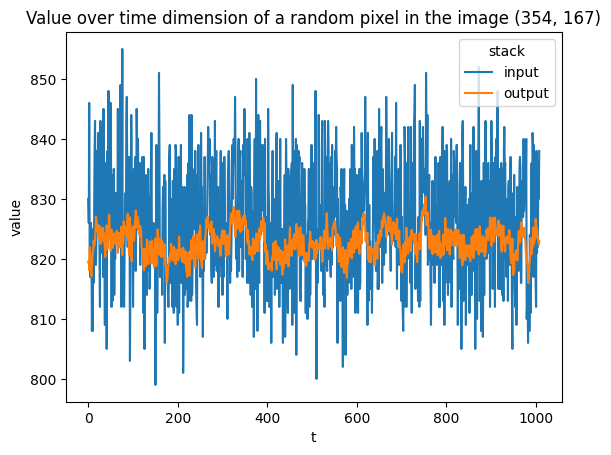

In [76]:
import random
import seaborn as sns
import pandas as pd

x, y = random.randint(0, input_image.shape[1]-1), random.randint(0, input_image.shape[2]-1)

data = pd.DataFrame({"input": input_image[:, x, y], "output": output_image[:, x, y]})
data = data.reset_index(names=["t"]).melt(id_vars=["t"], var_name="stack")

g = sns.lineplot(data=data, x="t", y="value", hue="stack")
g.set_title(f"Value over time dimension of a random pixel in the image ({x}, {y})")
g

We can also inspect the standard deviation of pixels along the time dimension to appreciate the overall denoising effect. We can see that while in the input image time-dependent noise is visible across the whole image, in the output image the variability is mostly related to signal dynamics.

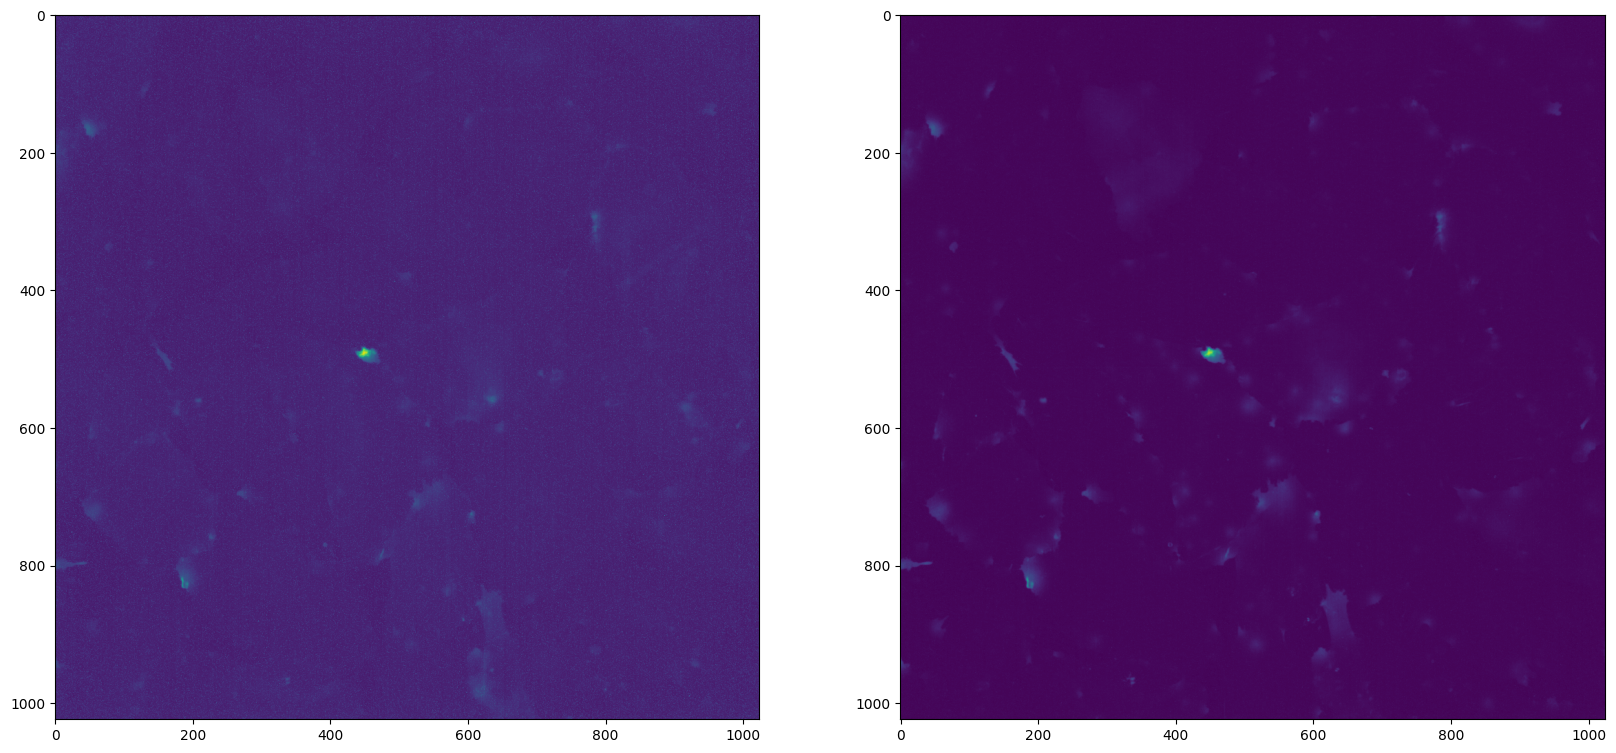

In [79]:
std_to_show = np.stack([input_image.std(axis=0), output_image.std(axis=0)])
fig, axs = plt.subplots(1, 2, squeeze=False, figsize=(20, 10))
for ax, img in zip(axs[0], std_to_show):
    ax.imshow(img, vmin=std_to_show.min(), vmax=std_to_show.max())
fig.show()